In [151]:
import cv2
import io
import numpy as np
import os
import pandas as pd
import sys
import time

from bson import ObjectId
from gridfs import GridFS
from PIL import Image, ImageFilter
from random import randint
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

sys.path.append('../..')
sys.path.append('../../../ajna_docs/commons')


In [152]:
from ajna_commons.flask.conf import SQL_URI
from ajna_commons.utils.images import mongo_image, recorta_imagem
from virasana.db import mongodb as db
from virasana.integracao.conformidade_alchemy import Conformidade
engine = create_engine(SQL_URI)

# Trazer lista de reefers

In [153]:
Session = sessionmaker(bind=engine)
session = Session()

In [154]:
rows = session.query(Conformidade.id_imagem).filter(Conformidade.isocode_group.startswith('R')).limit(1000).all()

60180b8a0be94217a2cf2344


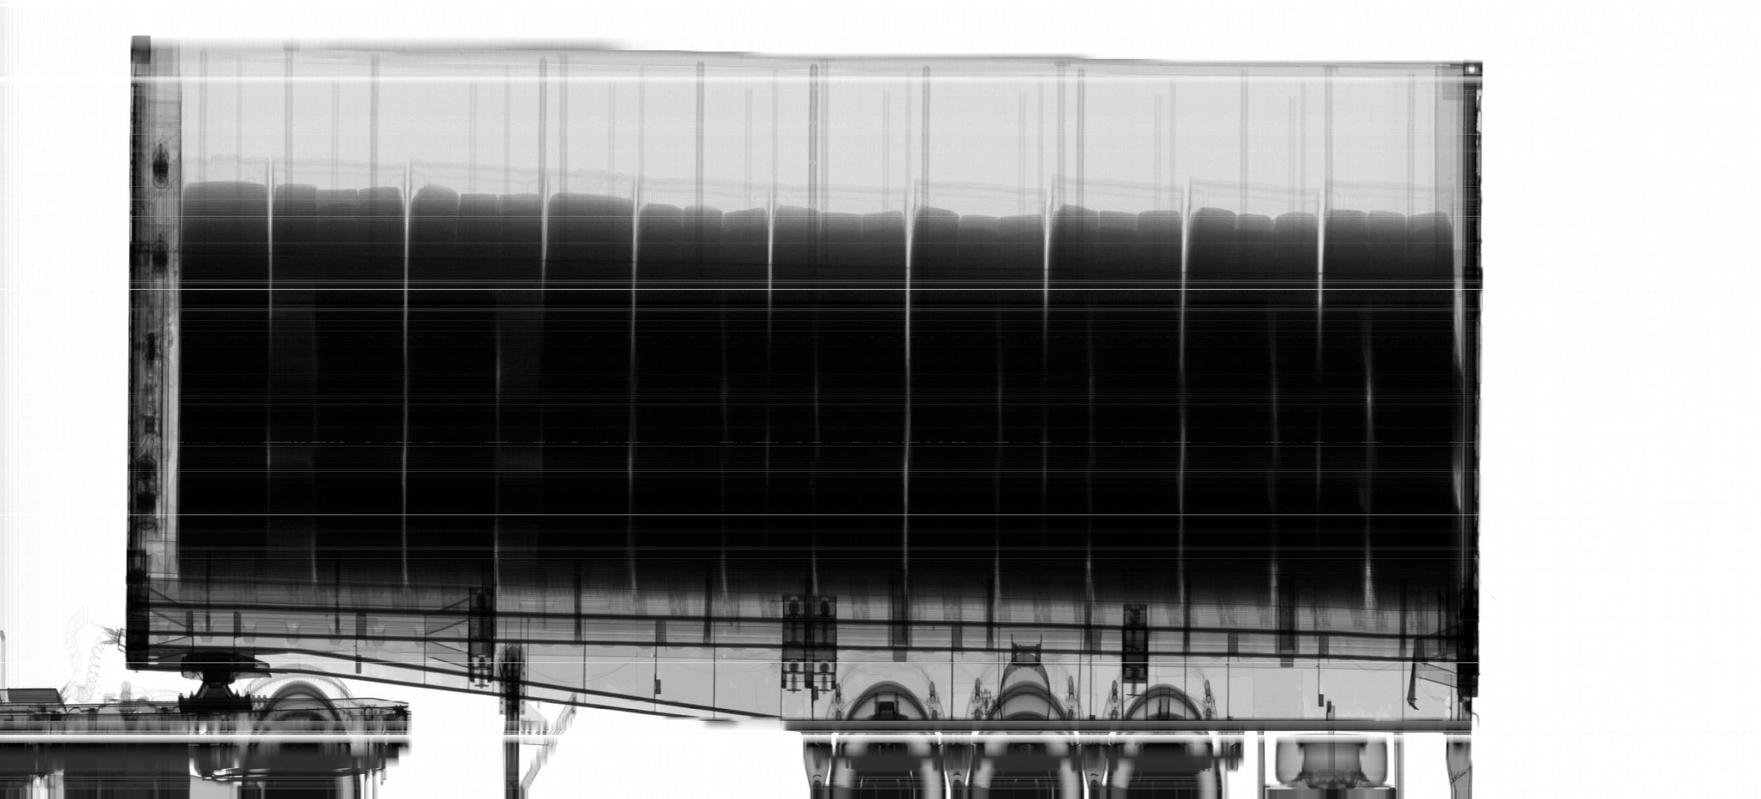

In [155]:
def rand_img(rows):
    i = randint(0, len(rows) - 1)
    _id  = rows[i][0]
    print(_id)
    image_bytes = mongo_image(db, _id)
    return Image.open(io.BytesIO(image_bytes))
rand_img(rows)

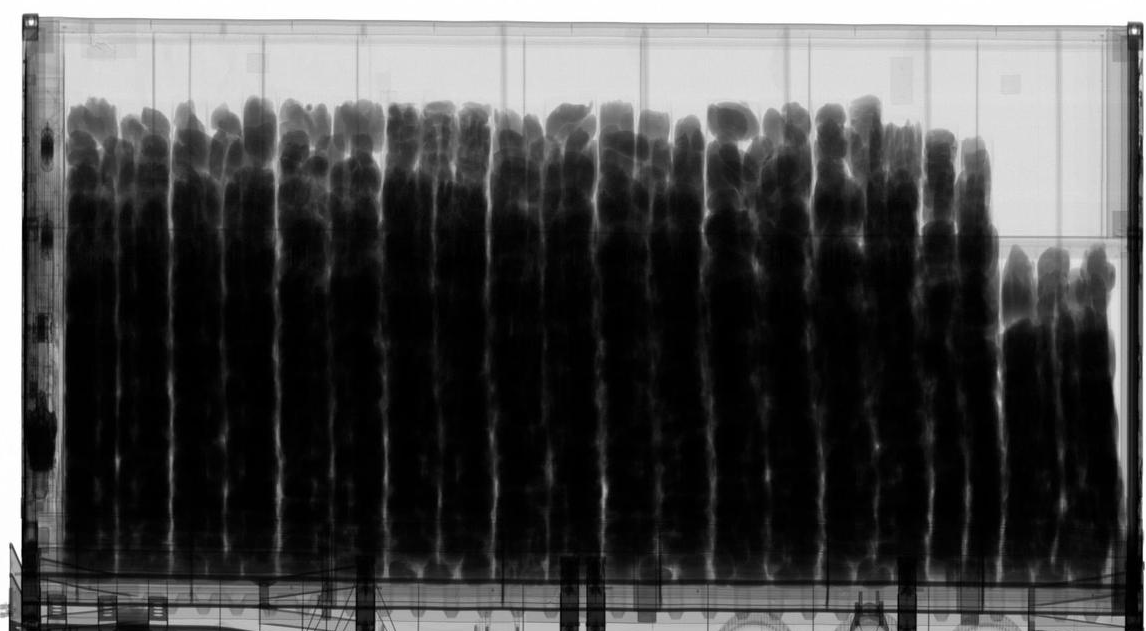

In [160]:
def rand_img_cropped(rows):
    i = randint(0, len(rows) - 1)
    _id  = rows[i][0]
    fs = GridFS(db)
    _id = ObjectId(_id)
    if fs.exists(_id):
        grid_data = fs.get(_id)
        preds = grid_data.metadata.get('predictions')
        if preds:
            bboxes = preds[0].get('bbox')
            image = grid_data.read()
            image = recorta_imagem(image, bboxes, pil=True)
            return image
rand_img_cropped(rows)

# Analisar nitidez

In [229]:
lista1 = session.query(Conformidade.id_imagem).filter(Conformidade.cod_recinto == 'EMBRAPORT').limit(1000).all()
lista2 = session.query(Conformidade.id_imagem).filter(Conformidade.cod_recinto == 'SBT').limit(1000).all()

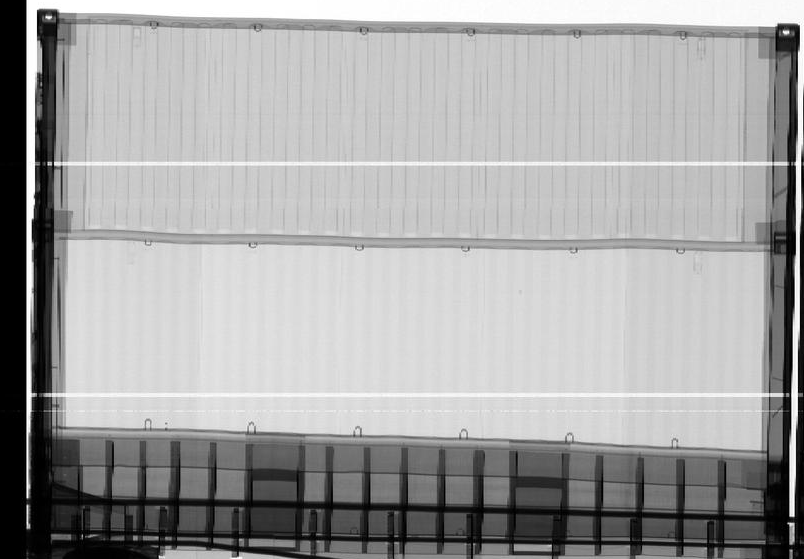

In [260]:
img1 = rand_img_cropped(lista1)
img1

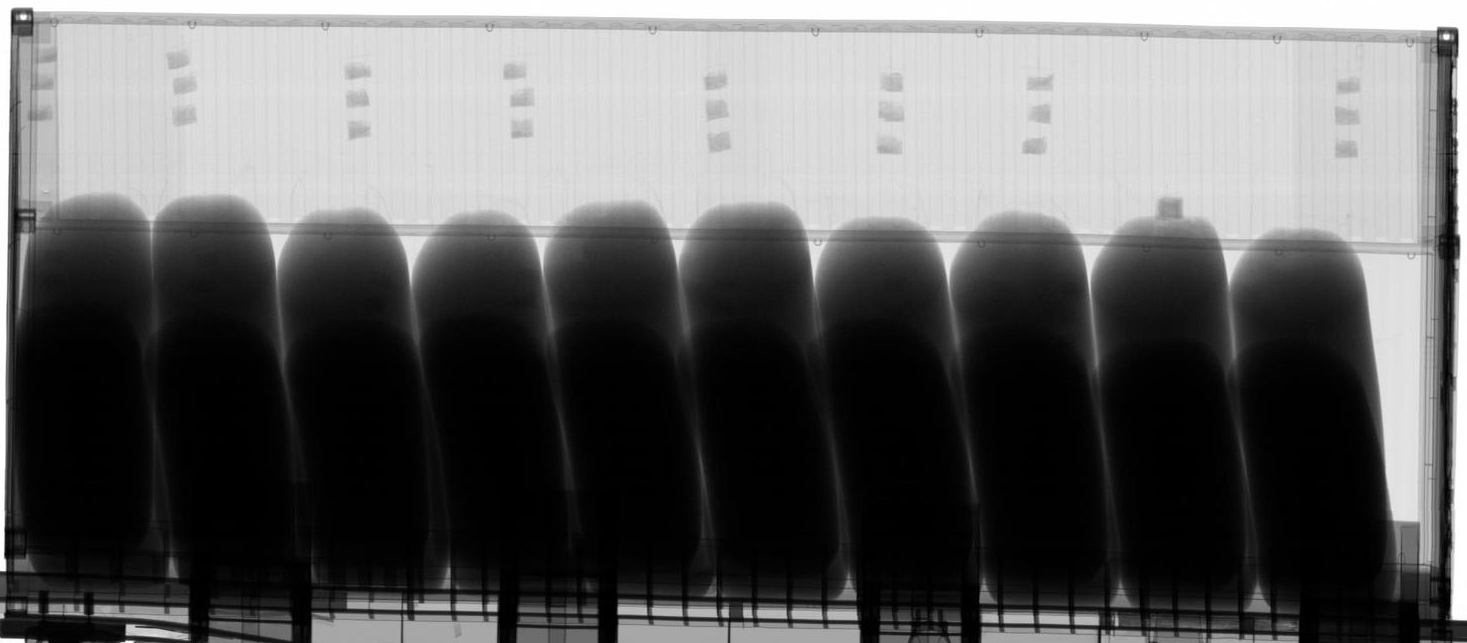

In [261]:
img2 = rand_img_cropped(lista2)
img2

In [271]:
int(cv2.Laplacian(cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2BGR), cv2.CV_8U).var())

228

In [270]:
int(cv2.Laplacian(cv2.cvtColor(np.array(img2), cv2.COLOR_RGB2BGR), cv2.CV_8U).var())

38

In [264]:
image1 = img1.filter(ImageFilter.FIND_EDGES)

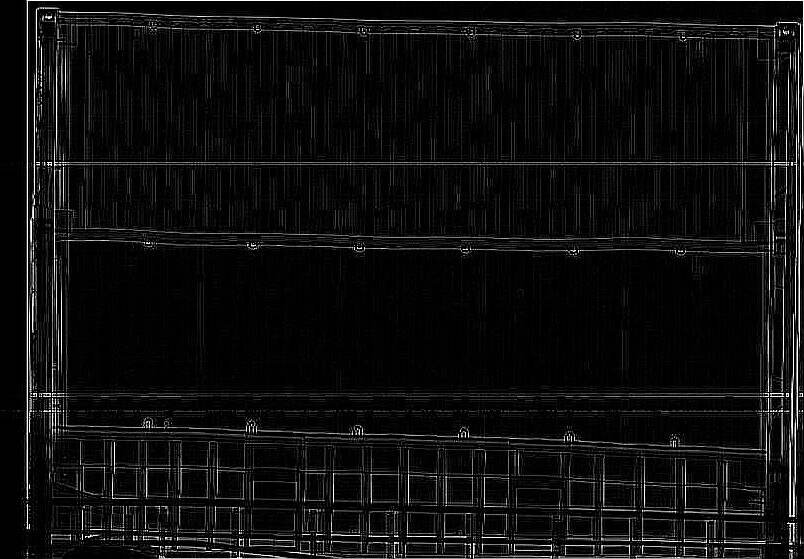

In [265]:
image1

In [266]:
np.array(image1).var()

1344.5560486282752

In [267]:
image2 = img2.filter(ImageFilter.FIND_EDGES)

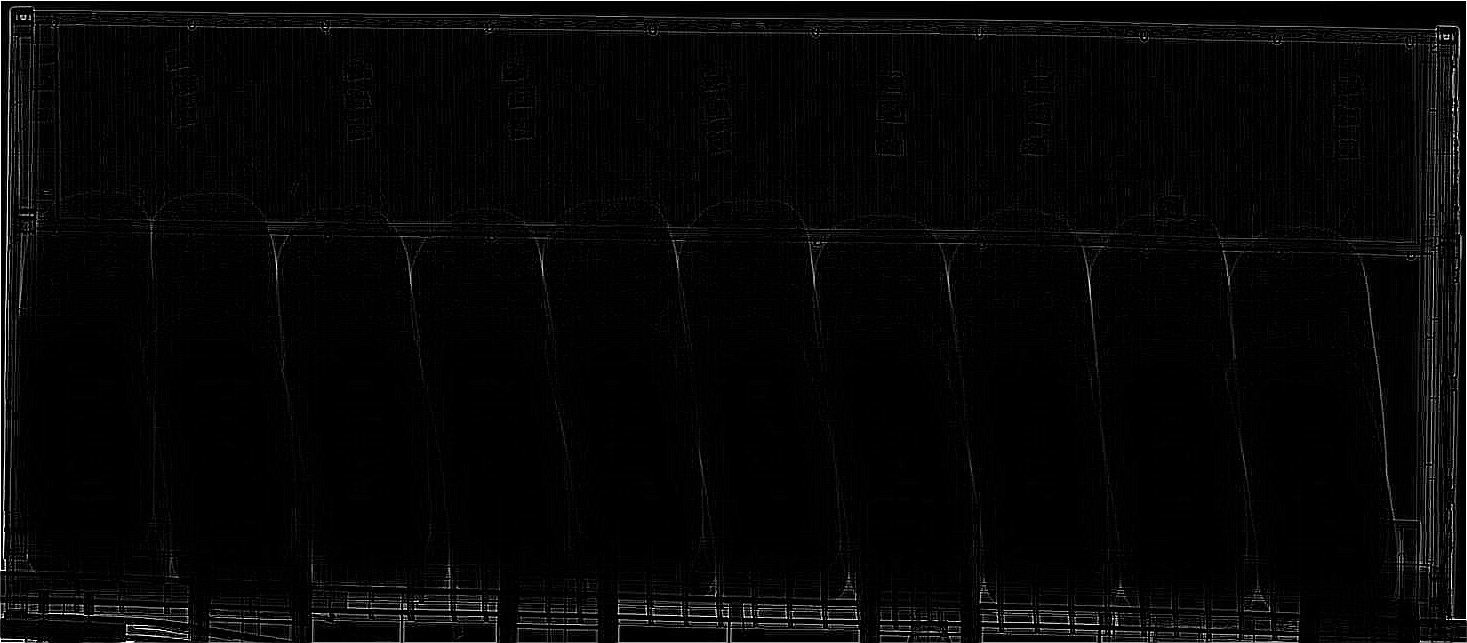

In [268]:
image2

In [269]:
np.array(image2).var()

515.3949202064459